This notebook is used to compare multiple training runs.

### Load libraries

In [1]:
import pathlib
from typing import List, Optional

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import sys
sys.path.append("/KataGoVisualizer/parsing_server")
sys.path.append("../../parsing_server")
import game_info

### Load run data

In [3]:
def get_run_df(data_dir: str) -> pd.DataFrame:
    sgf_paths = game_info.find_sgf_files(root=pathlib.Path(f"{data_dir}/selfplay"))

    game_infos = game_info.read_and_parse_all_files(
        sgf_paths,
        fast_parse=True,
    )

    df = pd.DataFrame(game_infos)
    print("gtypes:", df.gtype.unique())
    print("Number of cleanup games:", (df.gtype == "cleanuptraining").sum())

    # Filter to only normal games
    df = df.query("gtype == 'normal'")
    print("Fraction continuation:    ", df.is_continuation.mean())
    print("Fraction used_initial_pos:", df.used_initial_position.mean())
    print("max(init_turn_num)       :", df.init_turn_num.max())

    # Generate victim name v2
    df["victim_name_v2"] = "s" + df.victim_steps.astype(str) + "-v" + df.victim_visits.astype(str)

    print(f"Done parsing {data_dir}!")

    return df  # type: ignore

In [4]:
df_b6_i127 = get_run_df("/nas/ucb/tony/go-attack/weka/victimplay/full-curriculum-predictor-20220927-224321")
df_b10_i505 = get_run_df("/nas/ucb/tony/go-attack/training/vpred/b10-curr")
df_b20_i505 = get_run_df("/nas/ucb/tony/go-attack/training/vpred/b20-curr-cp505-init")

gtypes: ['normal']
Number of cleanup games: 0
Fraction continuation:     0.0
Fraction used_initial_pos: 0.0
max(init_turn_num)       : 0
Done parsing /nas/ucb/tony/go-attack/weka/victimplay/full-curriculum-predictor-20220927-224321!
gtypes: ['normal']
Number of cleanup games: 0
Fraction continuation:     0.0
Fraction used_initial_pos: 0.0
max(init_turn_num)       : 0
Done parsing /nas/ucb/tony/go-attack/training/vpred/b10-curr!
gtypes: ['normal']
Number of cleanup games: 0
Fraction continuation:     0.0
Fraction used_initial_pos: 0.0
max(init_turn_num)       : 0
Done parsing /nas/ucb/tony/go-attack/training/vpred/b20-curr-cp505-init!


### Plots

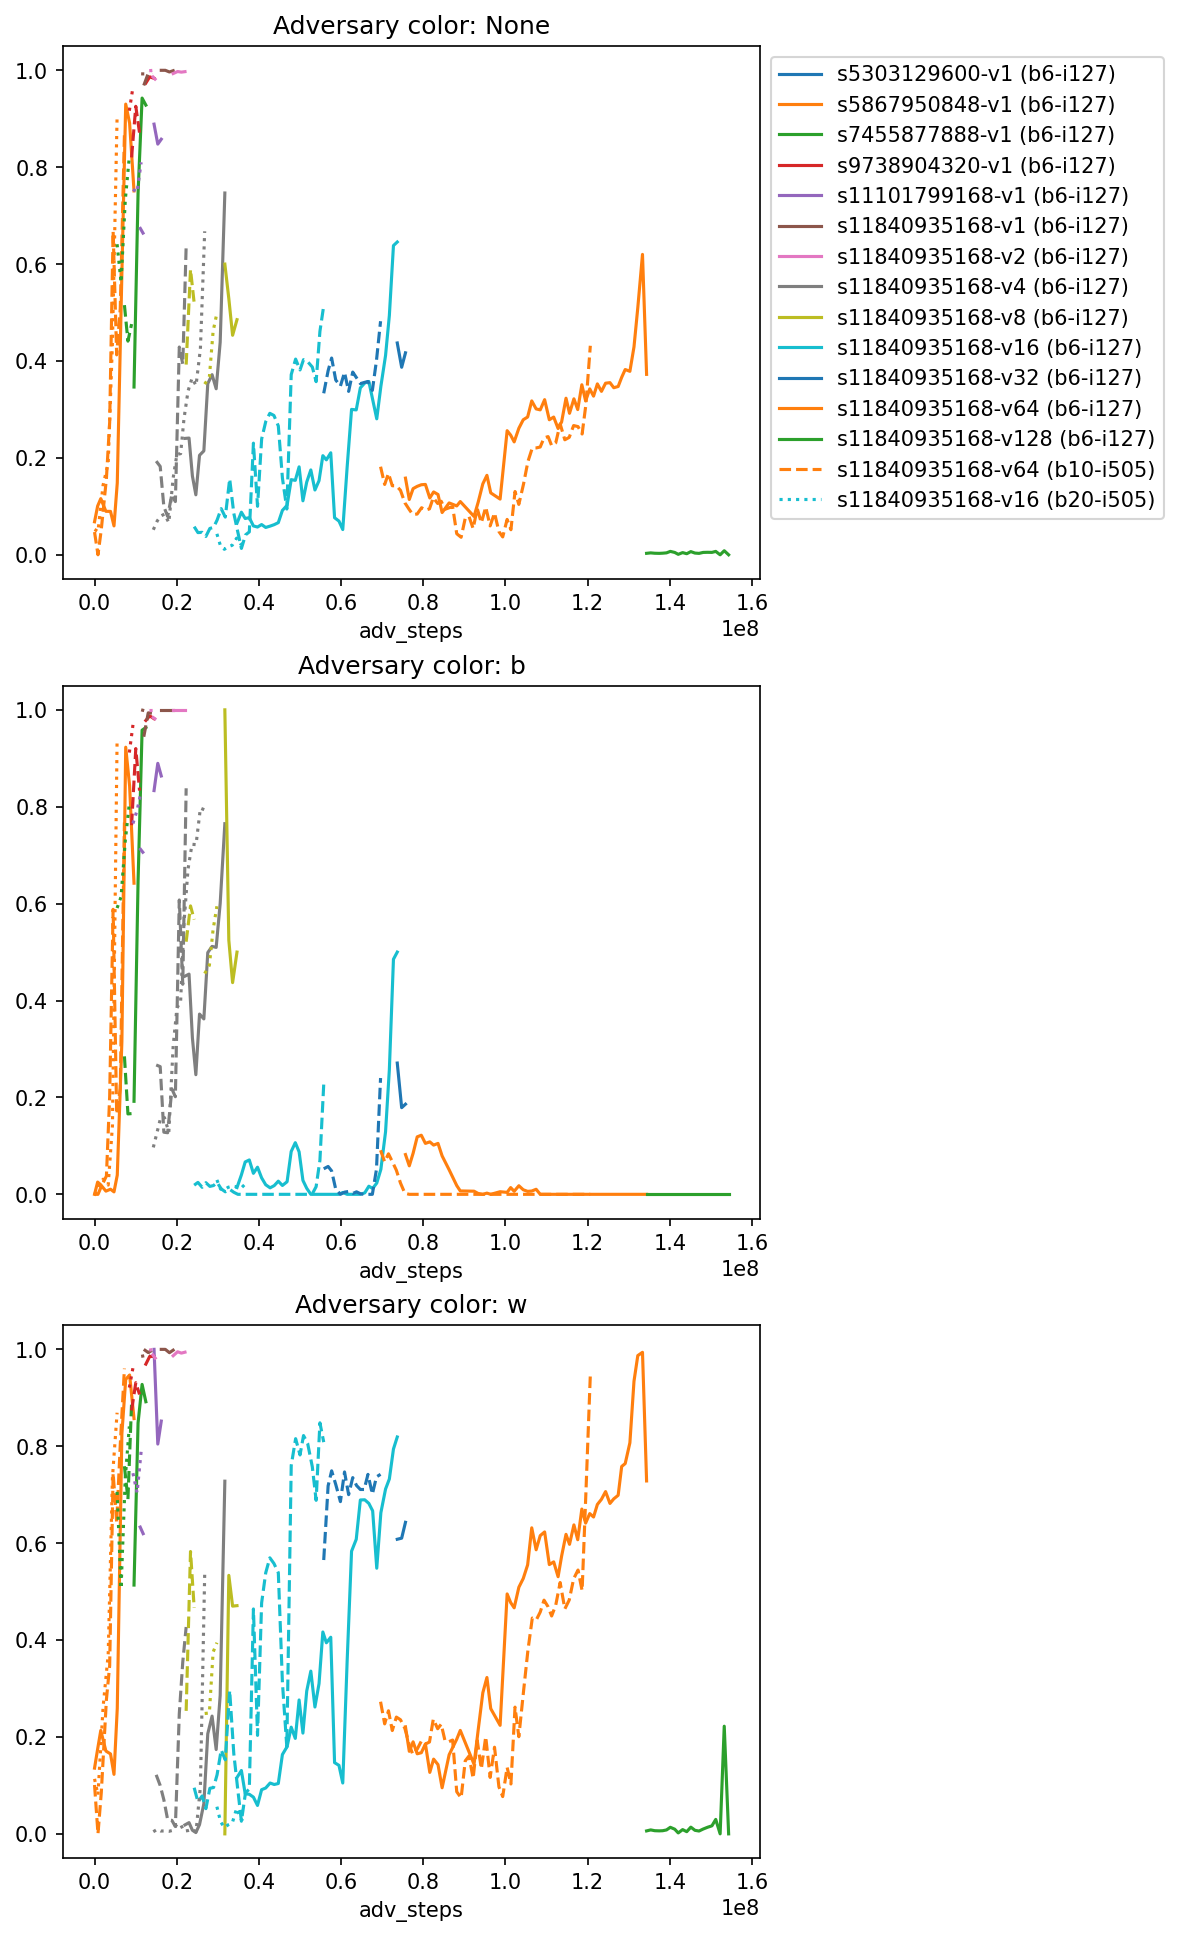

In [6]:
def plot_win_rate(df: pd.DataFrame, linestyle: str, label_suffix: str = "", show_all_labels: bool = False, filt: Optional[str] = None) -> None:
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    if filt is not None:
        df = df.query(filt)
    df19 = df.query("board_size == 19")

    indices = df19.groupby(["victim_steps", "victim_visits"]).size().index
    for i, vs_vv in enumerate(indices):
        steps, visits = vs_vv
        df19.query(f"victim_steps == {steps} and victim_visits == {visits}").groupby(
            "adv_steps"
        ).mean().adv_win.plot(
            label=f"{'' if (show_all_labels or i + 1 == len(indices)) else '_'}s{steps}-v{visits}{label_suffix}",
            c=colors[i % len(colors)],
            linestyle=linestyle,
        )

plt.figure(figsize=(6, 16), dpi=150)
for i, adv_color in enumerate((None, "b", "w")):
    plt.subplot(3, 1, i + 1)
    filt = f"adv_color == '{adv_color}'" if adv_color is not None else None
    plot_win_rate(df_b6_i127, linestyle="-", label_suffix=" (b6-i127)", filt=filt, show_all_labels=True)
    plot_win_rate(df_b10_i505, linestyle="--", label_suffix=" (b10-i505)", filt=filt)
    plot_win_rate(df_b20_i505, linestyle=":", label_suffix=" (b20-i505)", filt=filt)
    plt.title(f"Adversary color: {adv_color}")

    if adv_color is None:
        plt.legend(bbox_to_anchor=(1, 1), loc="upper left");